# **1. Perkenalan Dataset**


# **2. Import Library**

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# **3. Memuat Dataset**

In [ ]:
data = pd.read_csv('Dataset_inisiasi.csv', sep=',')

print(data.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [107]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [108]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


# **4. Exploratory Data Analysis (EDA)**

In [109]:
data['TotalSpendings'] = data.MntWines + data.MntFruits + data.MntMeatProducts + data.MntFishProducts + data.MntSweetProducts + data.MntGoldProds

Text(0, 0.5, 'Counts')

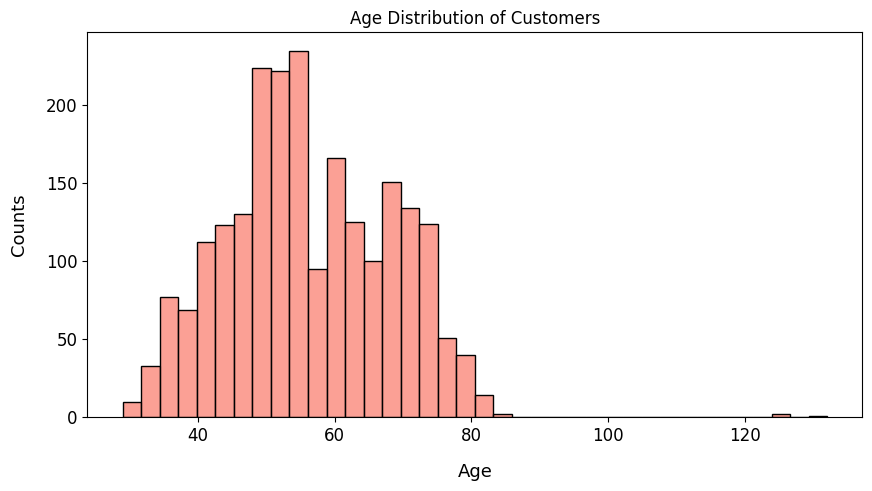

In [110]:
data['Age'] = 2025 - data['Year_Birth']

plt.figure(figsize=(10,5))
ax = sns.histplot(data=data, x='Age', color='salmon')
ax.set(title="Age Distribution of Customers")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Age', fontsize=13, labelpad=13)
plt.ylabel('Counts', fontsize=13, labelpad=13)

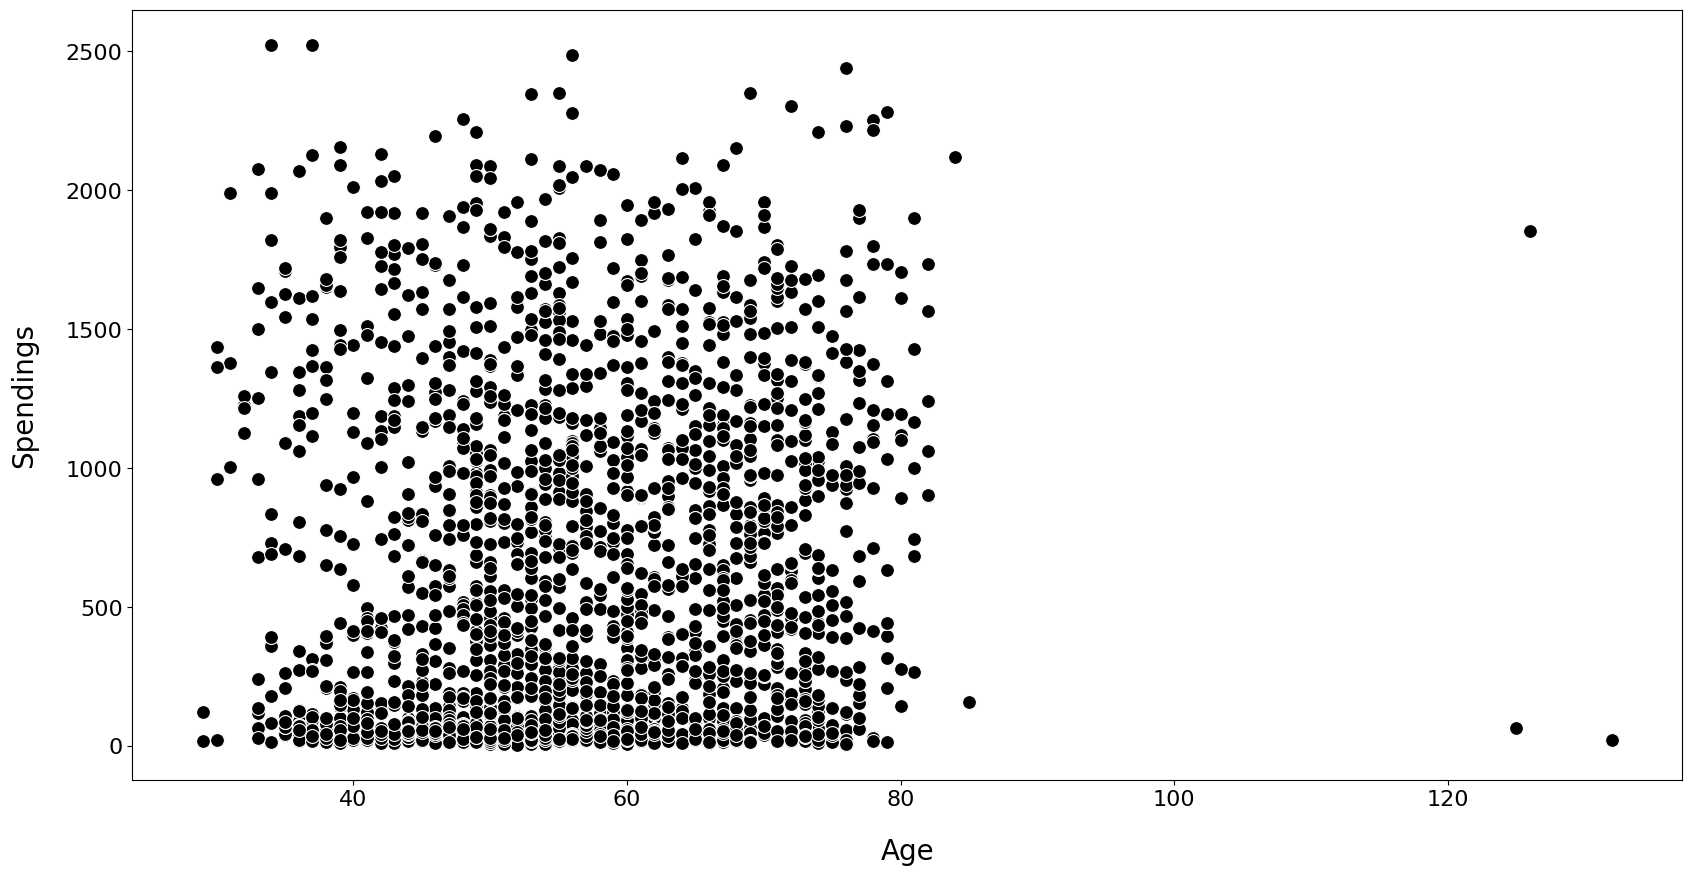

In [111]:
data['Age'] = 2025 - data['Year_Birth']

plt.figure(figsize=(20,10))
sns.scatterplot(x=data.Age, y=data.TotalSpendings, s=100, color ='black');

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Age', fontsize=20, labelpad=20)
plt.ylabel('Spendings', fontsize=20, labelpad=20);

# **5. Data Preprocessing**

In [112]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
latest_date = data['Dt_Customer'].max()
data['Tenure'] = (latest_date - data['Dt_Customer']).dt.days
data['TotalChildren'] = data['Kidhome'] + data['Teenhome']
data['TotalSpent'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
data['TotalPurchases'] = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [113]:
data['Income'] = data['Income'].fillna(0)
data['Income'] = np.log1p(data['Income'])
data['TotalSpent'] = np.log1p(data['TotalSpent'])
data['Tenure'] = np.log1p(data['Tenure'])

In [114]:
edu_mapping = {'Basic': 0, 'Graduation': 1, 'Master': 2, 'PhD': 3}
data['Education_Encoded'] = data['Education'].map(edu_mapping)

In [115]:

marital_mapping = {'Single': 0, 'Together': 1, 'Married': 1, 'Divorced': 0, 'Widow': 0}
data['Marital_Status_Encoded'] = data['Marital_Status'].map(marital_mapping)

In [116]:
features = ['Income', 'TotalSpent', 'Recency', 'NumWebVisitsMonth', 
            'Education_Encoded', 'Marital_Status_Encoded', 'TotalChildren',
            'Tenure', 'TotalPurchases']
X = data[features]

In [117]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [118]:
best_k = 3
best_score = 0

In [119]:
X_scaled = SimpleImputer(strategy='mean').fit_transform(X_scaled)

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    
    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters=best_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

In [120]:
print(f"Cluster Optimal adalah cluster ke-: {best_k} dengan Silhouette Score: {best_score:.2f}")

Cluster Optimal adalah cluster ke-: 2 dengan Silhouette Score: 0.23


## **b. Evaluasi Model Clustering**

In [121]:
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_scaled)

In [122]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_pca)

score = silhouette_score(X_pca, labels)
print(f'Silhouette Score after PCA: {score}')

Silhouette Score after PCA: 0.27184231135581366


In [123]:
numerical_features = features
X = data[numerical_features]
data[numerical_features] = scaler.inverse_transform(X)

## **c. Feature Selection (Opsional)**

In [124]:
# Tambah fitur interaksi
data['Income_Spent_Ratio'] = data['TotalSpent'] / data['Income']
data['WebPurchase_Frequency'] = data['NumWebPurchases'] / data['Tenure']

## **d. Visualisasi Hasil Clustering**


Korelasi Fitur dengan PCA:
                             PC1       PC2       PC3       PC4       PC5
TotalSpent              0.552929  0.187792  0.037859  0.019896  0.043709
TotalPurchases          0.537325  0.191661  0.063924  0.020432  0.061581
Income                  0.290642 -0.106359  0.284378  0.020560  0.271117
Education_Encoded       0.054950 -0.091742  0.363146  0.009289  0.704510
Tenure                  0.042200  0.841509  0.049303 -0.053919 -0.048829
Recency                 0.004233  0.099155 -0.567232  0.751145  0.302206
Marital_Status_Encoded -0.009364 -0.032203  0.613706  0.644149 -0.436765
TotalChildren          -0.382236  0.080557  0.249200  0.117741  0.361391
NumWebVisitsMonth      -0.412393  0.427522  0.137171 -0.052539  0.096847


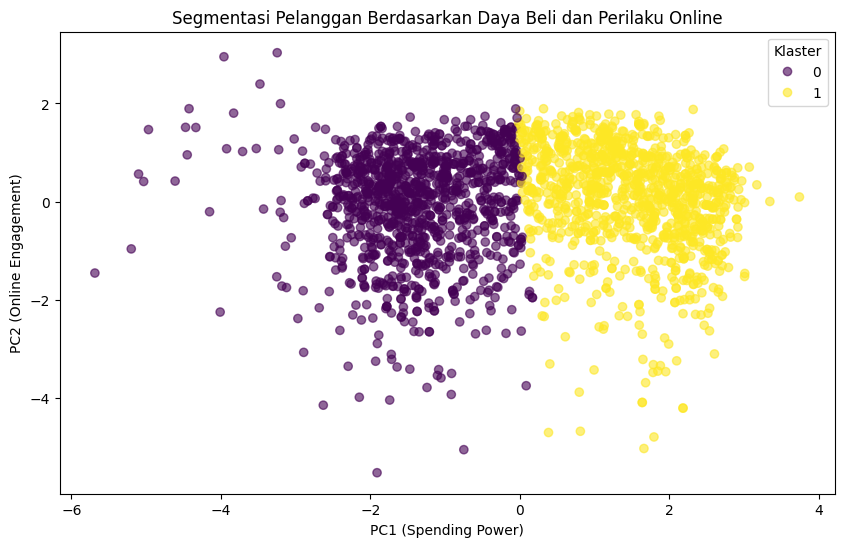

In [125]:
# Analisis komponen PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=numerical_features
)

print("\nKorelasi Fitur dengan PCA:")
print(loadings.sort_values(by='PC1', ascending=False))

# Plot dengan anotasi
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel('PC1 (Spending Power)')
plt.ylabel('PC2 (Online Engagement)')
plt.title('Segmentasi Pelanggan Berdasarkan Daya Beli dan Perilaku Online')
plt.legend(*scatter.legend_elements(), title='Klaster')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

In [126]:
X = data[features]
y = data['Cluster']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

### Interpretasi Target

In [129]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred_train = model.predict(X_train_imputed)
    y_pred_test = model.predict(X_test_imputed)
    
    print(f"\n{name} Performance:")
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Training F1-Score: {f1_score(y_train, y_pred_train, average='weighted'):.2f}")
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"Testing F1-Score: {f1_score(y_test, y_pred_test, average='weighted'):.2f}")


Random Forest Performance:
Training Accuracy: 1.00
Training F1-Score: 1.00
Testing Accuracy: 0.98
Testing F1-Score: 0.98

Logistic Regression Performance:
Training Accuracy: 0.99
Training F1-Score: 0.99
Testing Accuracy: 0.99
Testing F1-Score: 0.99


C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

In [130]:
cluster_analysis = data.groupby('Cluster').agg({
    'Income': ['mean', 'min', 'max'],
    'TotalSpent': ['mean', 'min', 'max'],
    'Education': lambda x: x.mode().iloc[0],
    'Marital_Status': lambda x: x.mode().iloc[0],
    'Recency': 'mean',
    'NumWebVisitsMonth': 'mean',
    'TotalChildren': 'mean'
})

for cluster in sorted(data['Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    print(f"- Rata-rata Income: {cluster_analysis.loc[cluster, ('Income', 'mean')]:.2f}")
    print(f"- Total Belanja: {cluster_analysis.loc[cluster, ('TotalSpent', 'mean')]:.2f}")
    print(f"- Pendidikan Dominan: {cluster_analysis.loc[cluster, ('Education', '<lambda>')]}")
    print(f"- Status Pernikahan: {cluster_analysis.loc[cluster, ('Marital_Status', '<lambda>')]}")


Cluster 0:
- Rata-rata Income: 23.05
- Total Belanja: 12.08
- Pendidikan Dominan: Graduation
- Status Pernikahan: Married

Cluster 1:
- Rata-rata Income: 24.11
- Total Belanja: 15.74
- Pendidikan Dominan: Graduation
- Status Pernikahan: Married


# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [ ]:
# Simpan data dengan label klaster
data.to_csv('Dataset_clustering.csv', index=False)

# Verifikasi
print(f"Data tersimpan dengan {len(data)} baris dan kolom:")
print(data.columns.tolist())

Data tersimpan dengan 2240 baris dan kolom:
['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'TotalSpendings', 'Age', 'Tenure', 'TotalChildren', 'TotalSpent', 'TotalPurchases', 'Education_Encoded', 'Marital_Status_Encoded', 'Cluster', 'Income_Spent_Ratio', 'WebPurchase_Frequency']
